In [1]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd


import seaborn as sns
import nibabel as nib

# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-12-04 02:32:10.574176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-04 02:32:10.729189: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-04 02:32:10.733333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-04 02:32:10.733360: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal
from layers import SpatialTransformer, VecInt, ResizeTransform, GumbelSoftmax


class ConvBlock(nn.Module):
    """
    Specific convolutional block followed by leakyrelu and normalization for unet.
    """

    def __init__(self, in_channels, out_channels, kernel=3, stride=1, padding=1,
                 apply_norm=False, apply_act=True, norm='IN'):
        super(ConvBlock, self).__init__()

        self.main = nn.Conv3d(in_channels, out_channels, kernel, stride, padding)
        nn.init.kaiming_normal_(self.main.weight)
        self.activation = nn.LeakyReLU(0.2)
        self.apply_norm = apply_norm
        self.norm = norm
        if apply_norm:
            if norm == 'IN':
                self.norm = nn.InstanceNorm3d(out_channels)
            elif norm == 'BN':
                self.norm = nn.BatchNorm3d(out_channels)
            elif norm == 'SN':
                self.norm = nn.utils.spectral_norm
        self.apply_act = apply_act
        self.drop = nn.Dropout3d(0.2)

    def forward(self, x):
        if self.apply_norm:
            if self.norm == 'SN':
                x = self.norm(self.main)(x)
            else:
                x = self.norm(self.main(x))
        else:
            x = self.main(x)
        if self.apply_act:
            x = self.activation(x)
        return self.drop(x)


class ResidualBlock(nn.Module):
    """
    Residual Block
    https://github.com/hhb072/IntroVAE
    """

    def __init__(self, in_channels=64, out_channels=64, scale=1.0, stride=1, apply_norm=False):
        super(ResidualBlock, self).__init__()

        midc = int(out_channels * scale)
        self.apply_norm = apply_norm

        if (in_channels is not out_channels) or (stride != 1):
            self.conv_expand = nn.Conv3d(in_channels=in_channels, out_channels=out_channels, kernel_size=1,
                                         stride=stride, padding=0,
                                         bias=False)
            nn.init.kaiming_normal_(self.conv_expand.weight)
        else:
            self.conv_expand = None

        self.conv1 = nn.Conv3d(in_channels=in_channels, out_channels=midc, kernel_size=3, stride=stride, padding=1,
                               bias=False)
        nn.init.kaiming_normal_(self.conv1.weight)
        self.relu1 = nn.LeakyReLU(0.2, inplace=False)
        self.conv2 = nn.Conv3d(in_channels=midc, out_channels=out_channels, kernel_size=3, stride=1, padding=1,
                               bias=False)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.relu2 = nn.LeakyReLU(0.2, inplace=False)

        if self.apply_norm:
            self.norm0 = nn.InstanceNorm3d(in_channels)
            self.norm1 = nn.InstanceNorm3d(midc)
            self.norm2 = nn.InstanceNorm3d(out_channels)

    def forward(self, x):
        if self.conv_expand is not None:
            if self.apply_norm:
                identity_data = self.conv_expand(nn.LeakyReLU(0.2)(self.norm0(x)))
            else:
                identity_data = self.conv_expand(nn.LeakyReLU(0.2)(x))
        else:
            identity_data = x

        if self.apply_norm:
            # output = self.relu1(self.norm1(self.conv1(x)))
            # output = self.conv2(output)
            # output = torch.add(output, identity_data)
            # output = self.relu2(self.norm2(output))
            output = self.conv1(self.relu1(self.norm1(x)))
            output = self.conv2(self.relu2(self.norm2(output)))
            output = torch.add(output, identity_data)
        else:
            # output = self.relu1(self.conv1(x))
            # output = self.conv2(output)
            # output = self.relu2(torch.add(output, identity_data))
            output = self.conv1(self.relu1(x))
            output = self.conv2(self.relu2(output))
            output = torch.add(output, identity_data)
        return output


class Downsample(nn.Module):
    """
    Downsampling
    """

    def __init__(self, in_channels, out_channels, kernel=3, apply_norm=True, apply_act=True, norm='IN'):
        super().__init__()

        self.main = nn.Conv3d(in_channels, out_channels, kernel, stride=2, padding=kernel // 2, bias=False)
        nn.init.kaiming_normal_(self.main.weight)
        self.apply_norm = apply_norm
        self.norm = norm
        if apply_norm:
            if norm == 'IN':
                self.norm = nn.InstanceNorm3d(out_channels)
            elif norm == 'BN':
                self.norm = nn.BatchNorm3d(out_channels)
            else:
                self.apply_norm = False
        self.apply_act = apply_act
        if self.apply_act:
            self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        if self.apply_norm:
            x = self.norm(self.main(x))
        else:
            x = self.main(x)
        if self.apply_act:
            x = self.activation(x)
        return x


class Encoder(nn.Module):
    def __init__(self, c_dim=1, channels=(16, 32, 64, 128, 128),
                 res=False, norm='IN', gumbel=False, scale=1):
        super(Encoder, self).__init__()

        self.conv_init = ConvBlock(c_dim, channels[0], 3, 1, 1, apply_norm=False)
        # self.enc0 = nn.Sequential(
        #     nn.Conv3d(c_dim, channels[0], 5, 1, 2, bias=False),
        #     nn.LeakyReLU(0.2),
        #     nn.AvgPool3d(2),
        # )

        if res:
            self.enc0 = nn.Sequential(
                ResidualBlock(channels[0], channels[1], scale=scale, stride=2, apply_norm=True))
            self.enc1 = nn.Sequential(
                ResidualBlock(channels[1], channels[2], scale=scale, stride=2, apply_norm=True))
            self.enc2 = nn.Sequential(
                ResidualBlock(channels[2], channels[3], scale=scale, stride=2, apply_norm=True))
            self.enc3 = nn.Sequential(
                ResidualBlock(channels[3], channels[4], scale=scale, stride=2, apply_norm=True))
            self.bottleneck = nn.Sequential(
                ResidualBlock(channels[4], channels[4], scale=scale, stride=1, apply_norm=True))
        else:
            self.enc0 = nn.Sequential(
                ConvBlock(channels[0], channels[1], stride=2, apply_norm=True, norm=norm))
            self.enc1 = nn.Sequential(
                ConvBlock(channels[1], channels[1], apply_norm=True, norm=norm),
                ConvBlock(channels[1], channels[2], stride=2, apply_norm=True, norm=norm))
            self.enc2 = nn.Sequential(
                ConvBlock(channels[2], channels[2], apply_norm=True, norm=norm),
                ConvBlock(channels[2], channels[3], stride=2, apply_norm=True, norm=norm))
            self.enc3 = nn.Sequential(
                ConvBlock(channels[3], channels[3], apply_norm=True, norm=norm),
                ConvBlock(channels[3], channels[4], stride=2, apply_norm=True, norm=norm))
            self.bottleneck = nn.Sequential(
                ConvBlock(channels[4], channels[4], apply_norm=True, apply_act=~gumbel))
        if gumbel:
            self.bottleneck.add_module('gumbel', GumbelSoftmax(temperature=0.5))

    def forward(self, x):
        x4 = self.conv_init(x)
        x3 = self.enc0(x4)
        x2 = self.enc1(x3)
        x1 = self.enc2(x2)
        x0 = self.enc3(x1)
        return self.bottleneck(x0), x1, x2, x3, x4


class SynthDecoder(nn.Module):
    def __init__(self, c_dim=1, channels=(16, 32, 64, 128, 128), res=False, scale=1.0):
        super(SynthDecoder, self).__init__()

        if res:
            self.dec1 = nn.Sequential(
                ResidualBlock(channels[-2] * 2, channels[-2], scale=scale, apply_norm=True))
            self.dec2 = nn.Sequential(
                ResidualBlock(channels[-3] + channels[-2], channels[-3], scale=scale, apply_norm=True))
            self.dec3 = nn.Sequential(
                ResidualBlock(channels[-4] + channels[-3], channels[-4], scale=scale, apply_norm=True))
            self.dec4 = nn.Sequential(
                ResidualBlock(channels[-5] + channels[-4], channels[-5], scale=scale, apply_norm=True))
            self.dec_final = nn.Sequential(
                nn.Conv3d(channels[0], c_dim, 3, 1, 1),
                nn.Sigmoid())

        else:
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-1] + channels[-2], channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True),
            )
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-2] + channels[-3], channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True),
            )
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-3] + channels[-4], channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True),
            )
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-4] + channels[-5], channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec_final = nn.Sequential(
                nn.Conv3d(channels[0], c_dim, 3, 1, 1),
                nn.Sigmoid()
            )

    def forward(self, x):
        x0, x1, x2, x3, x4 = x
        z1 = nn.Upsample(scale_factor=2, mode='trilinear')(x0)
        z1 = self.dec1(torch.cat((z1, x1), dim=1))  # 128x8x10x8
        z2 = nn.Upsample(scale_factor=2, mode='trilinear')(z1)
        z2 = self.dec2(torch.cat((z2, x2), dim=1))
        z3 = nn.Upsample(scale_factor=2, mode='trilinear')(z2)
        z3 = self.dec3(torch.cat((z3, x3), dim=1))
        z4 = nn.Upsample(scale_factor=2, mode='trilinear')(z3)
        z4 = self.dec4(torch.cat((z4, x4), dim=1))
        z = self.dec_final(z4)
        return z, z4, z3, z2, z1

class SynthDecoder_v2(nn.Module):
    def __init__(self, c_dim=1, channels=(16, 32, 64, 128, 128), res=False, scale=1.0):
        super(SynthDecoder_v2, self).__init__()

        if res:
            self.dec1 = nn.Sequential(
                ResidualBlock(channels[-2] * 2, channels[-2], scale=scale, apply_norm=True))
            self.dec2 = nn.Sequential(
                ResidualBlock(channels[-3] + channels[-2], channels[-3], scale=scale, apply_norm=True))
            self.dec3 = nn.Sequential(
                ResidualBlock(channels[-4] + channels[-3], channels[-4], scale=scale, apply_norm=True))
            self.dec4 = nn.Sequential(
                ResidualBlock(channels[-5] + channels[-4], channels[-5], scale=scale, apply_norm=True))
            self.dec_final = nn.Sequential(
                nn.Conv3d(channels[0], c_dim, 3, 1, 1),
                nn.Sigmoid())

        else:
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-1] + channels[-2], channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True),
            )
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-2] + channels[-3], channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True),
            )
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-3] + channels[-4], channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True),
            )
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-4] + channels[-5], channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec_final = nn.Sequential(
                nn.Conv3d(channels[0], c_dim, 3, 1, 1),
                nn.Sigmoid()
            )
        self.ref1 = ConvBlock(channels[-2], channels[-2], apply_norm=True)
        self.ref2 = ConvBlock(channels[-3], channels[-3], apply_norm=True)
        self.ref3 = ConvBlock(channels[-4], channels[-4], apply_norm=True)
        self.ref4 = ConvBlock(channels[-5], channels[-5], apply_norm=True)
    def forward(self, x):
        x0, x1, x2, x3, x4 = x
        z1 = nn.Upsample(scale_factor=2, mode='trilinear')(x0)
        z1 = self.dec1(torch.cat((z1, x1), dim=1))  # 128x8x10x8
        z2 = nn.Upsample(scale_factor=2, mode='trilinear')(z1)
        z2 = self.dec2(torch.cat((z2, x2), dim=1))
        z3 = nn.Upsample(scale_factor=2, mode='trilinear')(z2)
        z3 = self.dec3(torch.cat((z3, x3), dim=1))
        z4 = nn.Upsample(scale_factor=2, mode='trilinear')(z3)
        z4 = self.dec4(torch.cat((z4, x4), dim=1))
        z = self.dec_final(z4)
        return z, self.ref4(z4), self.ref3(z3), self.ref2(z2), self.ref1(z1)
    
class RegDecoder(nn.Module):
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), skip_connect=True, res=False):
        super(RegDecoder, self).__init__()

        self.skip_connect = skip_connect
        if res:
            if skip_connect:
                self.dec0 = nn.Sequential(
                    ResidualBlock(channels[-1] * 2, channels[-2], scale=0.5),  # channels[-2]/(channels[-1] * 2
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec1 = nn.Sequential(
                    ResidualBlock(channels[-2] * 3, channels[-3], scale=0.5),  # channels[-3]/(channels[-2] * 3)
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec2 = nn.Sequential(
                    ResidualBlock(channels[-3] * 3, channels[-4], scale=1.0),  # channels[-4]/(channels[-3] * 3)
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec3 = nn.Sequential(
                    ResidualBlock(channels[-4] * 3, channels[-5], scale=1.0),  # channels[-5]/(channels[-4] * 3)
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.final = ConvBlock(channels[0] * 3, channels[0], apply_norm=False)
            else:
                self.dec0 = nn.Sequential(
                    ResidualBlock(channels[-1] * 2, channels[-2], scale=channels[-2]/(channels[-1] * 2)),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec1 = nn.Sequential(
                    ResidualBlock(channels[-2], channels[-3], scale=channels[-3]/(channels[-2])),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec2 = nn.Sequential(
                    ResidualBlock(channels[-3], channels[-4], scale=channels[-4]/(channels[-3])),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec3 = nn.Sequential(
                    ResidualBlock(channels[-4], channels[-5], scale=channels[-5]/(channels[-4])),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.final = ConvBlock(channels[0], channels[0], apply_norm=False)
        else:
            if skip_connect:
                self.dec0 = nn.Sequential(
                    ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                    ConvBlock(channels[-2], channels[-2], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec1 = nn.Sequential(
                    ConvBlock(channels[-2] * 3, channels[-3], apply_norm=True),
                    ConvBlock(channels[-3], channels[-3], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec2 = nn.Sequential(
                    ConvBlock(channels[-3] * 3, channels[-4], apply_norm=True),
                    ConvBlock(channels[-4], channels[-4], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec3 = nn.Sequential(
                    ConvBlock(channels[-4] * 3, channels[-5], apply_norm=True),
                    ConvBlock(channels[-5], channels[-5], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.final = ConvBlock(channels[0] * 3, channels[0], apply_norm=False)
            else:
                self.dec0 = nn.Sequential(
                    ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                    ConvBlock(channels[-2], channels[-2], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec1 = nn.Sequential(
                    ConvBlock(channels[-2], channels[-3], apply_norm=True),
                    ConvBlock(channels[-3], channels[-3], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec2 = nn.Sequential(
                    ConvBlock(channels[-3], channels[-4], apply_norm=True),
                    ConvBlock(channels[-4], channels[-4], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.dec3 = nn.Sequential(
                    ConvBlock(channels[-4], channels[-5], apply_norm=True),
                    ConvBlock(channels[-5], channels[-5], apply_norm=True),
                    nn.Upsample(scale_factor=2, mode='trilinear'))
                self.final = ConvBlock(channels[0], channels[0], apply_norm=False)

        # init flow layer with small weights and bias
        self.flow = nn.Conv3d(channels[0], c_dim, 3, 1, 1)
        # self.flow.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

    def forward(self, z):
        if self.skip_connect:
            z0, z1, z2, z3, z4, = z
            r1 = self.dec0(z0)  # 128x8x10x8
            r2 = self.dec1(torch.cat((r1, z1), dim=1))  # 64x16x20x16
            r3 = self.dec2(torch.cat((r2, z2), dim=1))  # 32x40x32
            r4 = self.dec3(torch.cat((r3, z3), dim=1))  # 16x64x80x64
            r = self.final(torch.cat((r4, z4), dim=1))

        else:
            r1 = self.dec0(z)  # 128x8x10x8
            r2 = self.dec1(r1)  # 64x16x20x16
            r3 = self.dec2(r2)  # 32x40x32
            r4 = self.dec3(r3)  # 16x64x80x64
            r = self.final(r4)

        flow = self.flow(r)
        return flow


class RegCascadedDecoder(nn.Module):
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), res=False):
        super(RegCascadedDecoder, self).__init__()

        self.resize = ResizeTransform(vel_resize=0.5, ndims=3)  # upsample and scale deformation field
        if res:
            self.dec0 = ResidualBlock(channels[-1] * 2, channels[-2], scale=0.5)
            self.dec1 = ResidualBlock(channels[-2] * 2, channels[-3], scale=0.5)
            self.dec2 = ResidualBlock(channels[-3] * 2, channels[-4], scale=0.5)
            self.dec3 = ResidualBlock(channels[-4] * 2, channels[-5], scale=0.5)
            self.dec4 = ResidualBlock(channels[-5] * 2, channels[-5], scale=0.5)
        else:
            self.dec0 = nn.Sequential(
                ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True))
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-2] * 2, channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True))
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-3] * 2, channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True))
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-4] * 2, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-5] * 2, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))

        self.flow0 = nn.Conv3d(channels[-2], c_dim, 1, 1)
        # self.flow0.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow0.weight.shape))
        self.flow0.bias = nn.Parameter(torch.zeros(self.flow0.bias.shape))

        self.flow1 = nn.Conv3d(channels[-3], c_dim, 1, 1)
        # self.flow1.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow1.weight.shape))
        self.flow1.bias = nn.Parameter(torch.zeros(self.flow1.bias.shape))
        self.STN1 = SpatialTransformer((16, 20, 16))
        self.vecint1 = VecInt((16, 20, 16), nsteps=7, transformer=self.STN1)

        self.flow2 = nn.Conv3d(channels[-4], c_dim, 1, 1)
        # self.flow2.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow2.weight.shape))
        self.flow2.bias = nn.Parameter(torch.zeros(self.flow2.bias.shape))
        self.STN2 = SpatialTransformer((32, 40, 32))
        self.vecint2 = VecInt((32, 40, 32), nsteps=7, transformer=self.STN2)

        self.flow3 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        # self.flow3.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow3.weight.shape))
        self.flow3.bias = nn.Parameter(torch.zeros(self.flow3.bias.shape))
        self.STN3 = SpatialTransformer((64, 80, 64))
        self.vecint3 = VecInt((64, 80, 64), nsteps=7, transformer=self.STN3)

        self.flow4 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        # self.flow4.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow4.weight.shape))
        self.flow4.bias = nn.Parameter(torch.zeros(self.flow4.bias.shape))
        self.STN4 = SpatialTransformer((128, 160, 128))
        self.vecint4 = VecInt((128, 160, 128), nsteps=7, transformer=self.STN4)

    def forward(self, z):
        z0, z1, z2, z3, z4 = z

        r0 = self.dec0(z0)
        flow1 = self.resize(self.flow0(r0))
        flow1 = self.vecint1(flow1)
        # r1 = nn.Upsample(scale_factor=2, mode='trilinear')(r0)

        z1_src, z1_tgt = z1
        r1 = self.dec1(torch.cat((self.STN1(z1_src, flow1), z1_tgt), dim=1))
        flow1 = flow1 + self.STN1(self.flow1(r1), flow1)  # flow composition
        flow2 = self.resize(flow1)
        flow2 = self.vecint2(flow2)

        z2_src, z2_tgt = z2
        r2 = self.dec2(torch.cat((self.STN2(z2_src, flow2), z2_tgt), dim=1))
        flow2 = flow2 + self.STN2(self.flow2(r2), flow2)  # flow composition
        flow3 = self.resize(flow2)
        flow3 = self.vecint3(flow3)

        z3_src, z3_tgt = z3
        r3 = self.dec3(torch.cat((self.STN3(z3_src, flow3), z3_tgt), dim=1))
        flow3 = flow3 + self.STN3(self.flow3(r3), flow3)  # flow composition
        flow4 = self.resize(flow3)
        flow4 = self.vecint4(flow4)

        z4_src, z4_tgt = z4
        r4 = self.dec4(torch.cat((self.STN4(z4_src, flow4), z4_tgt), dim=1))
        flow4 = flow4 + self.STN4(self.flow4(r4), flow4)  # flow composition

        # flow4 = self.vecint(flow4)
        return flow4, flow3, flow2, flow1

class RegCascadedDecoder_v4(nn.Module):
    #  each level, concatenate synthesis fixed/moving features + flow from previous level
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), res=False):
        super(RegCascadedDecoder_v4, self).__init__()

        self.resize = ResizeTransform(vel_resize=0.5, ndims=3)  # upsample and scale deformation field
        if res:
            self.dec0 = ResidualBlock(channels[-1] * 2, channels[-2], scale=channels[-2]/(channels[-1] * 2))
            self.dec1 = ResidualBlock(channels[-2] * 2 + 3, channels[-3], scale=channels[-3]/(channels[-2] * 2 + 3))
            self.dec2 = ResidualBlock(channels[-3] * 2 + 3, channels[-4], scale=channels[-4]/(channels[-3] * 2 + 3))
            self.dec3 = ResidualBlock(channels[-4] * 2 + 3, channels[-5], scale=channels[-4]/(channels[-5] * 2 + 3))
            self.dec4 = ResidualBlock(channels[-5] * 2 + 3, channels[-5], scale=channels[-5]/(channels[-5] * 2 + 3))
        else:
            self.dec0 = nn.Sequential(
                ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True))
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-2] * 2 + 3, channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True))
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-3] * 2 + 3, channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True))
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-4] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-5] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))

        self.flow0 = nn.Conv3d(channels[-2], c_dim, 1, 1)
        self.flow0.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow0.weight.shape))
        self.flow0.bias = nn.Parameter(torch.zeros(self.flow0.bias.shape))

        self.flow1 = nn.Conv3d(channels[-3], c_dim, 1, 1)
        self.flow1.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow1.weight.shape))
        self.flow1.bias = nn.Parameter(torch.zeros(self.flow1.bias.shape))
        self.STN1 = SpatialTransformer((16, 20, 16))
        self.vecint1 = VecInt((16, 20, 16), nsteps=7, transformer=self.STN1)

        self.flow2 = nn.Conv3d(channels[-4], c_dim, 1, 1)
        self.flow2.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow2.weight.shape))
        self.flow2.bias = nn.Parameter(torch.zeros(self.flow2.bias.shape))
        self.STN2 = SpatialTransformer((32, 40, 32))
        self.vecint2 = VecInt((32, 40, 32), nsteps=7, transformer=self.STN2)

        self.flow3 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow3.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow3.weight.shape))
        self.flow3.bias = nn.Parameter(torch.zeros(self.flow3.bias.shape))
        self.STN3 = SpatialTransformer((64, 80, 64))
        self.vecint3 = VecInt((64, 80, 64), nsteps=7, transformer=self.STN3)

        self.flow4 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow4.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow4.weight.shape))
        self.flow4.bias = nn.Parameter(torch.zeros(self.flow4.bias.shape))
        self.STN4 = SpatialTransformer((128, 160, 128))
        self.vecint4 = VecInt((128, 160, 128), nsteps=7, transformer=self.STN4)

        self.unc = nn.Conv3d(channels[-5], c_dim*3, 1, 1)

    def forward(self, z):
        z0, z1, z2, z3, z4 = z

        r0 = self.dec0(z0)
        flow1 = self.resize(self.flow0(r0))
        flow1 = self.vecint1(flow1)

        z1_src, z1_tgt = z1
        r1 = self.dec1(torch.cat((self.STN1(z1_src, flow1.detach()), z1_tgt, flow1), dim=1))
        flow1 = flow1 + self.STN1(self.flow1(r1), flow1)  # flow composition
        flow2 = self.resize(flow1)
        flow2 = self.vecint2(flow2)

        z2_src, z2_tgt = z2
        r2 = self.dec2(torch.cat((self.STN2(z2_src, flow2.detach()), z2_tgt, flow2), dim=1))
        flow2 = flow2 + self.STN2(self.flow2(r2), flow2)  # flow composition
        flow3 = self.resize(flow2)
        flow3 = self.vecint3(flow3)

        z3_src, z3_tgt = z3
        r3 = self.dec3(torch.cat((self.STN3(z3_src, flow3.detach()), z3_tgt, flow3), dim=1))
        flow3 = flow3 + self.STN3(self.flow3(r3), flow3)  # flow composition
        flow4 = self.resize(flow3)
        flow4 = self.vecint4(flow4)

        z4_src, z4_tgt = z4
        r4 = self.dec4(torch.cat((self.STN4(z4_src, flow4.detach()), z4_tgt, flow4), dim=1))
        flow4 = flow4 + self.STN4(self.flow4(r4), flow4)  # flow composition

        # flow4 = self.vecint(flow4)
        return flow4, flow3, flow2, flow1, torch.exp(self.unc(r4))

class RegCascadedDecoder_v5(nn.Module):
    #  each level, concatenate synthesis fixed/moving features + flow from previous level
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), res=False):
        super(RegCascadedDecoder_v5, self).__init__()

        self.resize = ResizeTransform(vel_resize=0.5, ndims=3)  # upsample and scale deformation field
        if res:
            self.dec0 = ResidualBlock(channels[-1] * 2, channels[-2], scale=channels[-2]/(channels[-1] * 2))
            self.dec1 = ResidualBlock(channels[-2] * 2 + 3, channels[-3], scale=channels[-3]/(channels[-2] * 2 + 3))
            self.dec2 = ResidualBlock(channels[-3] * 2 + 3, channels[-4], scale=channels[-4]/(channels[-3] * 2 + 3))
            self.dec3 = ResidualBlock(channels[-4] * 2 + 3, channels[-5], scale=channels[-4]/(channels[-5] * 2 + 3))
            self.dec4 = ResidualBlock(channels[-5] * 2 + 3, channels[-5], scale=channels[-5]/(channels[-5] * 2 + 3))
        else:
            self.dec0 = nn.Sequential(
                ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True))
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-2] * 2 + 3, channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True))
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-3] * 2 + 3, channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True))
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-4] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-5] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))

        self.flow0 = nn.Conv3d(channels[-2], c_dim, 1, 1)
        self.flow0.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow0.weight.shape))
        self.flow0.bias = nn.Parameter(torch.zeros(self.flow0.bias.shape))

        self.flow1 = nn.Conv3d(channels[-3], c_dim, 1, 1)
        self.flow1.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow1.weight.shape))
        self.flow1.bias = nn.Parameter(torch.zeros(self.flow1.bias.shape))
        self.STN1 = SpatialTransformer((16, 20, 16))
        self.vecint1 = VecInt((16, 20, 16), nsteps=7, transformer=self.STN1)

        self.flow2 = nn.Conv3d(channels[-4], c_dim, 1, 1)
        self.flow2.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow2.weight.shape))
        self.flow2.bias = nn.Parameter(torch.zeros(self.flow2.bias.shape))
        self.STN2 = SpatialTransformer((32, 40, 32))
        self.vecint2 = VecInt((32, 40, 32), nsteps=7, transformer=self.STN2)

        self.flow3 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow3.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow3.weight.shape))
        self.flow3.bias = nn.Parameter(torch.zeros(self.flow3.bias.shape))
        self.STN3 = SpatialTransformer((64, 80, 64))
        self.vecint3 = VecInt((64, 80, 64), nsteps=7, transformer=self.STN3)

        self.flow4 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow4.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow4.weight.shape))
        self.flow4.bias = nn.Parameter(torch.zeros(self.flow4.bias.shape))
        self.STN4 = SpatialTransformer((128, 160, 128))
        self.vecint4 = VecInt((128, 160, 128), nsteps=7, transformer=self.STN4)

        self.unc = nn.Conv3d(channels[-5], c_dim, 1, 1)

    def forward(self, z):
        z0, z1, z2, z3, z4 = z

        r0 = self.dec0(z0)
        flow1 = self.resize(self.flow0(r0))
        flow1 = self.vecint1(flow1)

        z1_src, z1_tgt = z1
        r1 = self.dec1(torch.cat((self.STN1(z1_src, flow1.detach()), z1_tgt, flow1), dim=1))
        flow1 = flow1 + self.STN1(self.flow1(r1), flow1)  # flow composition
        flow2 = self.resize(flow1)
        flow2 = self.vecint2(flow2)

        z2_src, z2_tgt = z2
        r2 = self.dec2(torch.cat((self.STN2(z2_src, flow2.detach()), z2_tgt, flow2), dim=1))
        flow2 = flow2 + self.STN2(self.flow2(r2), flow2)  # flow composition
        flow3 = self.resize(flow2)
        flow3 = self.vecint3(flow3)

        z3_src, z3_tgt = z3
        r3 = self.dec3(torch.cat((self.STN3(z3_src, flow3.detach()), z3_tgt, flow3), dim=1))
        flow3 = flow3 + self.STN3(self.flow3(r3), flow3)  # flow composition
        flow4 = self.resize(flow3)
        flow4 = self.vecint4(flow4)

        z4_src, z4_tgt = z4
        r4 = self.dec4(torch.cat((self.STN4(z4_src, flow4.detach()), z4_tgt, flow4), dim=1))
        flow4 = flow4 + self.STN4(self.flow4(r4), flow4)  # flow composition

        # flow4 = self.vecint(flow4)
        return flow4, flow3, flow2, flow1, torch.exp(self.unc(r4))

class RegCascadedDecoder_v3(nn.Module):
    #  each level, concatenate synthesis fixed/moving features + flow from previous level
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), res=False):
        super(RegCascadedDecoder_v3, self).__init__()

        self.resize = ResizeTransform(vel_resize=0.5, ndims=3)  # upsample and scale deformation field
        if res:
            self.dec0 = ResidualBlock(channels[-1] * 2, channels[-2], scale=channels[-2]/(channels[-1] * 2))
            self.dec1 = ResidualBlock(channels[-2] * 2 + 3, channels[-3], scale=channels[-3]/(channels[-2] * 2 + 3))
            self.dec2 = ResidualBlock(channels[-3] * 2 + 3, channels[-4], scale=channels[-4]/(channels[-3] * 2 + 3))
            self.dec3 = ResidualBlock(channels[-4] * 2 + 3, channels[-5], scale=channels[-4]/(channels[-5] * 2 + 3))
            self.dec4 = ResidualBlock(channels[-5] * 2 + 3, channels[-5], scale=channels[-5]/(channels[-5] * 2 + 3))
        else:
            self.dec0 = nn.Sequential(
                ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True))
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-2] * 2 + 3, channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True))
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-3] * 2 + 3, channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True))
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-4] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-5] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))

        self.flow0 = nn.Conv3d(channels[-2], c_dim, 1, 1)
        self.flow0.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow0.weight.shape))
        self.flow0.bias = nn.Parameter(torch.zeros(self.flow0.bias.shape))

        self.flow1 = nn.Conv3d(channels[-3], c_dim, 1, 1)
        self.flow1.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow1.weight.shape))
        self.flow1.bias = nn.Parameter(torch.zeros(self.flow1.bias.shape))
        self.STN1 = SpatialTransformer((16, 20, 16))
        self.vecint1 = VecInt((16, 20, 16), nsteps=7, transformer=self.STN1)

        self.flow2 = nn.Conv3d(channels[-4], c_dim, 1, 1)
        self.flow2.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow2.weight.shape))
        self.flow2.bias = nn.Parameter(torch.zeros(self.flow2.bias.shape))
        self.STN2 = SpatialTransformer((32, 40, 32))
        self.vecint2 = VecInt((32, 40, 32), nsteps=7, transformer=self.STN2)

        self.flow3 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow3.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow3.weight.shape))
        self.flow3.bias = nn.Parameter(torch.zeros(self.flow3.bias.shape))
        self.STN3 = SpatialTransformer((64, 80, 64))
        self.vecint3 = VecInt((64, 80, 64), nsteps=7, transformer=self.STN3)

        self.flow4 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow4.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow4.weight.shape))
        self.flow4.bias = nn.Parameter(torch.zeros(self.flow4.bias.shape))
        self.STN4 = SpatialTransformer((128, 160, 128))
        self.vecint4 = VecInt((128, 160, 128), nsteps=7, transformer=self.STN4)

        #self.unc = nn.Conv3d(channels[-5], c_dim*3, 1, 1)

    def forward(self, z):
        z0, z1, z2, z3, z4 = z

        r0 = self.dec0(z0)
        flow1 = self.resize(self.flow0(r0))
        flow1 = self.vecint1(flow1)

        z1_src, z1_tgt = z1
        r1 = self.dec1(torch.cat((self.STN1(z1_src, flow1.detach()), z1_tgt, flow1), dim=1))
        flow1 = flow1 + self.STN1(self.flow1(r1), flow1)  # flow composition
        flow2 = self.resize(flow1)
        flow2 = self.vecint2(flow2)

        z2_src, z2_tgt = z2
        r2 = self.dec2(torch.cat((self.STN2(z2_src, flow2.detach()), z2_tgt, flow2), dim=1))
        flow2 = flow2 + self.STN2(self.flow2(r2), flow2)  # flow composition
        flow3 = self.resize(flow2)
        flow3 = self.vecint3(flow3)

        z3_src, z3_tgt = z3
        r3 = self.dec3(torch.cat((self.STN3(z3_src, flow3.detach()), z3_tgt, flow3), dim=1))
        flow3 = flow3 + self.STN3(self.flow3(r3), flow3)  # flow composition
        flow4 = self.resize(flow3)
        flow4 = self.vecint4(flow4)

        z4_src, z4_tgt = z4
        r4 = self.dec4(torch.cat((self.STN4(z4_src, flow4.detach()), z4_tgt, flow4), dim=1))
        flow4 = flow4 + self.STN4(self.flow4(r4), flow4)  # flow composition

        # flow4 = self.vecint(flow4)
        return flow4, flow3, flow2, flow1
   
class RegCascadedDecoder_v6(nn.Module):
    #  each level, concatenate synthesis fixed/moving features + flow from previous level
    def __init__(self, c_dim=3, channels=(16, 32, 64, 128, 128), res=False):
        super(RegCascadedDecoder_v6, self).__init__()

        self.resize = ResizeTransform(vel_resize=0.5, ndims=3)  # upsample and scale deformation field
        if res:
            self.dec0 = ResidualBlock(channels[-1] * 2, channels[-2], scale=channels[-2]/(channels[-1] * 2))
            self.dec1 = ResidualBlock(channels[-2] * 2 + 3, channels[-3], scale=channels[-3]/(channels[-2] * 2 + 3))
            self.dec2 = ResidualBlock(channels[-3] * 2 + 3, channels[-4], scale=channels[-4]/(channels[-3] * 2 + 3))
            self.dec3 = ResidualBlock(channels[-4] * 2 + 3, channels[-5], scale=channels[-4]/(channels[-5] * 2 + 3))
            self.dec4 = ResidualBlock(channels[-5] * 2 + 3, channels[-5], scale=channels[-5]/(channels[-5] * 2 + 3))
        else:
            self.dec0 = nn.Sequential(
                ConvBlock(channels[-1] * 2, channels[-2], apply_norm=True),
                ConvBlock(channels[-2], channels[-2], apply_norm=True))
            self.dec1 = nn.Sequential(
                ConvBlock(channels[-2] * 2 + 3, channels[-3], apply_norm=True),
                ConvBlock(channels[-3], channels[-3], apply_norm=True))
            self.dec2 = nn.Sequential(
                ConvBlock(channels[-3] * 2 + 3, channels[-4], apply_norm=True),
                ConvBlock(channels[-4], channels[-4], apply_norm=True))
            self.dec3 = nn.Sequential(
                ConvBlock(channels[-4] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))
            self.dec4 = nn.Sequential(
                ConvBlock(channels[-5] * 2 + 3, channels[-5], apply_norm=True),
                ConvBlock(channels[-5], channels[-5], apply_norm=True))

        self.flow0 = nn.Conv3d(channels[-2], c_dim, 1, 1)
        self.flow0.weight = nn.Parameter(Normal(0, 1e-5).sample(self.flow0.weight.shape))
        self.flow0.bias = nn.Parameter(torch.zeros(self.flow0.bias.shape))

        self.flow1 = nn.Conv3d(channels[-3], c_dim, 1, 1)
        self.flow1.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow1.weight.shape))
        self.flow1.bias = nn.Parameter(torch.zeros(self.flow1.bias.shape))
        self.STN1 = SpatialTransformer((16, 20, 16))
        self.vecint1 = VecInt((16, 20, 16), nsteps=7, transformer=self.STN1)

        self.flow2 = nn.Conv3d(channels[-4], c_dim, 1, 1)
        self.flow2.weight = nn.Parameter(Normal(0, 1e-4).sample(self.flow2.weight.shape))
        self.flow2.bias = nn.Parameter(torch.zeros(self.flow2.bias.shape))
        self.STN2 = SpatialTransformer((32, 40, 32))
        self.vecint2 = VecInt((32, 40, 32), nsteps=7, transformer=self.STN2)

        self.flow3 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow3.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow3.weight.shape))
        self.flow3.bias = nn.Parameter(torch.zeros(self.flow3.bias.shape))
        self.STN3 = SpatialTransformer((64, 80, 64))
        self.vecint3 = VecInt((64, 80, 64), nsteps=7, transformer=self.STN3)

        self.flow4 = nn.Conv3d(channels[-5], c_dim, 1, 1)
        self.flow4.weight = nn.Parameter(Normal(0, 1e-3).sample(self.flow4.weight.shape))
        self.flow4.bias = nn.Parameter(torch.zeros(self.flow4.bias.shape))
        self.STN4 = SpatialTransformer((128, 160, 128))
        self.vecint4 = VecInt((128, 160, 128), nsteps=7, transformer=self.STN4)
        self.drop = nn.Dropout3d(0.5)

    def forward(self, z):
        z0, z1, z2, z3, z4 = z

        r0 = self.dec0(z0)
        flow1 = self.resize(self.flow0(r0))
        flow1 = self.vecint1(flow1)

        z1_src, z1_tgt = z1
        r1 = self.dec1(torch.cat((self.STN1(z1_src, flow1.detach()), z1_tgt, flow1), dim=1))
        flow1 = flow1 + self.STN1(self.flow1(r1), flow1)  # flow composition
        flow2 = self.resize(flow1)
        flow2 = self.vecint2(flow2)

        z2_src, z2_tgt = z2
        r2 = self.dec2(torch.cat((self.STN2(z2_src, flow2.detach()), z2_tgt, flow2), dim=1))
        flow2 = flow2 + self.STN2(self.flow2(r2), flow2)  # flow composition
        flow3 = self.resize(flow2)
        flow3 = self.vecint3(flow3)

        z3_src, z3_tgt = z3
        r3 = self.dec3(torch.cat((self.STN3(z3_src, flow3.detach()), z3_tgt, flow3), dim=1))
        flow3 = flow3 + self.STN3(self.flow3(r3), flow3)  # flow composition
        flow4 = self.resize(flow3)
        flow4 = self.vecint4(flow4)

        z4_src, z4_tgt = z4
        r4 = self.dec4(torch.cat((self.STN4(z4_src, flow4.detach()), z4_tgt, flow4), dim=1))
        r4 = self.drop(r4)
        flow4 = flow4 + self.STN4(self.flow4(r4), flow4)  # flow composition

        # flow4 = self.vecint(flow4)
        return flow4, flow3, flow2, flow1

class UNet(nn.Module):
    """
    A basic U-Net with an encoder and decoder module
    """

    def __init__(self, cdim=1, channels=(16, 32, 64, 128, 128), res=False, gumbel=False):
        """
        res: if True, use residual blocks; otherwise use two convolutions
        gumbel: apply Gumbel Softmax to the latent variable to squeeze into categorical vector
                compress bottleneck information
        """
        super(UNet, self).__init__()

        self.encoder = Encoder(cdim, channels, res=res, gumbel=gumbel)
        self.decoder = SynthDecoder(cdim, channels, res=res)

    def forward(self, x):
        # Encoding
        z = self.encoder(x)

        # Decoding + Skip-Connections
        y, _, _, _, _ = self.decoder(z)
        return y

    def set_required_grad(self, level=-1):
        """
        level=0: freeze the bottleneck layer (in the encoder)
        else: freeze the n low-level layers
        """
        if level == -1:
            for param in self.encoder.parameters():
                param.requires_grad = True
            for param in self.decoder.parameters():
                param.requires_grad = True
        if level == -2: #freeze entire encoder
            for param in self.encoder.parameters():
                param.requires_grad = False
            for param in self.decoder.parameters():
                param.requires_grad = True
        else:
            for i, layer in enumerate(reversed(list(self.encoder.children()))):
                if i <= level:
                    for param in layer.parameters():
                        param.requires_grad = False
                else:
                    for param in layer.parameters():
                        param.requires_grad = True

            for i, layer in enumerate(list(self.decoder.children())):
                if i <= (level-1):
                    for param in layer.parameters():
                        param.requires_grad = False
                else:
                    for param in layer.parameters():
                        param.requires_grad = True


class VoxelMorph(nn.Module):
    """
    A basic VoxelMorph
    """
    def __init__(self, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128), res=False, gumbel=False):
        """
        res: if True, use residual blocks; otherwise use two convolutions
        gumbel: apply Gumbel Softmax to the latent variable to squeeze into categorical vector
                compress bottleneck information
        """
        super(VoxelMorph, self).__init__()

        self.encoder = Encoder(2, channels, res=res, gumbel=gumbel)
        self.decoder = SynthDecoder(3, channels, res=res)
        self.transformer = SpatialTransformer(image_size)
        self.vectint = VecInt(image_size, 7)

    def forward(self, src, tgt):
        # Encoding
        z = self.encoder(torch.cat((src, tgt), dim=1))
        # Decoding + Skip-Connections
        flow, _, _, _, _ = self.decoder(z)
        flow = self.vectint(flow)
        reg = self.transformer(src, flow)
        return reg, flow


class JSR(nn.Module):
    def __init__(self, cdim=1, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128),
                 separate_decoders=False, skip_connect=True, res=False, skip_detach=False, gumbel=False, scale=1.0):
        """
        cdim: input image dimension
        channels: number of feature channels at each of the encoding / decoding convolutions
        image_size:
        separate_decoders: if true, no weight-sharing between MR and CBCT synthesis decoders;
                           if false, use weight-sharing
        skip_connect: if True, add skip connection from synthesis decoding branch to registration decoding branch
        """
        super(JSR, self).__init__()

        self.encoder_src = Encoder(cdim, channels, res=res, gumbel=gumbel, scale=scale)
        self.encoder_tgt = Encoder(cdim, channels, res=res, gumbel=gumbel, scale=scale)
        self.separate_decoders = separate_decoders
        self.skip_connect = skip_connect
        self.skip_detach = skip_detach
        if separate_decoders:
            self.decoder_synth_src = SynthDecoder(cdim, channels, res=res)
            self.decoder_synth_tgt = SynthDecoder(cdim, channels, res=res)
        else:
            self.decoder_synth = SynthDecoder(cdim, channels, res=res)
        self.decoder_reg = RegDecoder(3, channels, skip_connect=skip_connect, res=res)
        self.transformer = SpatialTransformer(image_size)
        self.vectint = VecInt(image_size, 7)

    def forward(self, x, y):
        z_src = self.encoder_src(x)
        z_tgt = self.encoder_tgt(y)

        # Synthesis decoding branch
        if self.separate_decoders:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth_src(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth_tgt(z_tgt)
        else:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth(z_tgt)

        # Registration decoding branch
        if self.skip_connect:
            if self.skip_detach:
                flow = self.decoder_reg([torch.cat((z_src[0], z_tgt[0]), dim=1),
                                         torch.cat((z_src1, z_tgt1), dim=1).detach(),
                                         torch.cat((z_src2, z_tgt2), dim=1).detach(),
                                         torch.cat((z_src3, z_tgt3), dim=1).detach(),
                                         torch.cat((z_src4, z_tgt4), dim=1).detach()])
            else:
                flow = self.decoder_reg([torch.cat((z_src[0], z_tgt[0]), dim=1),
                                         torch.cat((z_src1, z_tgt1), dim=1),
                                         torch.cat((z_src2, z_tgt2), dim=1),
                                         torch.cat((z_src3, z_tgt3), dim=1),
                                         torch.cat((z_src4, z_tgt4), dim=1)])
        else:
            flow = self.decoder_reg(torch.cat((z_src[0], z_tgt[0]), dim=1))

        return flow, src_synth, tgt_synth

    def warp_image(self, img, flow):
        return self.transformer(img, flow)

    def exp(self, flow):
        return self.vectint(flow)

    def set_required_grad(self, mode='synth'):
        """
        mode = 'synth': encoder_src + encoder_tgt + decoder_synth to true
        mode = 'reg': all to true
        mode = 'false': all to false
        """
        if mode == 'synth':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        elif mode == 'reg':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'joint':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'false':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        else:
            raise NotImplementedError


class JSRCascade(nn.Module):
    def __init__(self, cdim=1, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128),
                 separate_decoders=False, res=False, version='v1'):
        """
        cdim: input image dimension
        channels: number of feature channels at each of the encoding / decoding convolutions
        image_size:
        separate_decoders: if true, no weight-sharing between MR and CBCT synthesis decoders;
                           if false, use weight-sharing
        skip_connect: if True, add skip connection from synthesis decoding branch to registration decoding branch
        """
        super(JSRCascade, self).__init__()

        self.encoder_src = Encoder(cdim, channels, res=res)
        self.encoder_tgt = Encoder(cdim, channels, res=res)
        self.separate_decoders = separate_decoders
        if separate_decoders:
            self.decoder_synth_src = SynthDecoder(cdim, channels, res=res)
            self.decoder_synth_tgt = SynthDecoder(cdim, channels, res=res)
        else:
            self.decoder_synth = SynthDecoder(cdim, channels, res=res)
        if version == 'v1':
            self.decoder_reg = RegCascadedDecoder(3, channels, res=res)
        elif version == 'v2':
            self.decoder_reg = RegCascadedDecoder_v2(3, channels, res=res)
        elif version == 'v3':
            self.decoder_reg = RegCascadedDecoder_v3(3, channels, res=res)
        elif version == 'v4':
            self.decoder_reg = RegCascadedDecoder_v4(3, channels, res=res)
        elif version == 'v5':
            self.decoder_reg = RegCascadedDecoder_v5(3, channels, res=res)
        elif version == 'v6':
            self.decoder_reg = RegCascadedDecoder_v6(3, channels, res=res)
        else:
            raise NotImplementedError("Have not implemented the specified registration decoder!")
        self.transformer = SpatialTransformer(image_size)
        self.vectint = VecInt(image_size, 7)

    def forward(self, x, y):
        z_src = self.encoder_src(x)
        z_tgt = self.encoder_tgt(y)

        # Synthesis decoding branch
        if self.separate_decoders:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth_src(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth_tgt(z_tgt)
        else:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth(z_tgt)

        # Registration decoding branch [128x160, 64x80, 32x40, 16x20]
        flows = self.decoder_reg([torch.cat((z_src[0], z_tgt[0]), dim=1),
                                  [z_src1, z_tgt1],
                                  [z_src2, z_tgt2],
                                  [z_src3, z_tgt3],
                                  [z_src4, z_tgt4]])

        # Downsample the synthetic images [128x160, 64x80, 32x40, 16x20]
        src_synths = [src_synth]
        tgt_synths = [tgt_synth]
        for i in range(3):
            src_synths.append(nn.AvgPool3d(2)(src_synths[-1]))
            tgt_synths.append(nn.AvgPool3d(2)(tgt_synths[-1]))

        return flows, src_synths, tgt_synths
    def warp_image(self, img, flow):
        return self.transformer(img, flow)

    def exp(self, flow):
        return self.vectint(flow)

    def set_required_grad(self, mode='synth'):
        """
        mode = 'synth': encoder_src + encoder_tgt + decoder_synth to true
        mode = 'reg': all to true
        mode = 'false': all to false
        """
        if mode == 'synth':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        elif mode == 'reg':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'joint':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'false':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        else:
            raise NotImplementedError

class JSRCascade_v2(nn.Module):
    def __init__(self, cdim=1, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128),
                 separate_decoders=False, res=False, version='v1'):
        """
        cdim: input image dimension
        channels: number of feature channels at each of the encoding / decoding convolutions
        image_size:
        separate_decoders: if true, no weight-sharing between MR and CBCT synthesis decoders;
                           if false, use weight-sharing
        skip_connect: if True, add skip connection from synthesis decoding branch to registration decoding branch
        """
        super(JSRCascade_v2, self).__init__()

        self.encoder_src = Encoder(cdim, channels, res=res)
        self.encoder_tgt = Encoder(cdim, channels, res=res)
        self.intraCBCT = ConvBlock(cdim, cdim)
        self.intraMR = ConvBlock(cdim, cdim)
        self.separate_decoders = separate_decoders
        if separate_decoders:
            self.decoder_synth_src = SynthDecoder(cdim, channels, res=res)
            self.decoder_synth_tgt = SynthDecoder(cdim, channels, res=res)
        else:
            self.decoder_synth = SynthDecoder(cdim, channels, res=res)
        if version == 'v1':
            self.decoder_reg = RegCascadedDecoder(3, channels, res=res)
        elif version == 'v2':
            self.decoder_reg = RegCascadedDecoder_v2(3, channels, res=res)
        elif version == 'v3':
            self.decoder_reg = RegCascadedDecoder_v3(3, channels, res=res)
        elif version == 'v4':
            self.decoder_reg = RegCascadedDecoder_v4(3, channels, res=res)
        elif version == 'v5':
            self.decoder_reg = RegCascadedDecoder_v5(3, channels, res=res)
        elif version == 'v6':
            self.decoder_reg = RegCascadedDecoder_v6(3, channels, res=res)
        else:
            raise NotImplementedError("Have not implemented the specified registration decoder!")
        self.transformer = SpatialTransformer(image_size)
        self.vectint = VecInt(image_size, 7)

    def forward(self, x, y):
        z_src = self.encoder_src(x)
        z_tgt = self.encoder_tgt(y)

        # Synthesis decoding branch
        if self.separate_decoders:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth_src(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth_tgt(z_tgt)
        else:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth(z_tgt)

        # Registration decoding branch [128x160, 64x80, 32x40, 16x20]
        flows = self.decoder_reg([torch.cat((z_src[0], z_tgt[0]), dim=1),
                                  [z_src1, z_tgt1],
                                  [z_src2, z_tgt2],
                                  [z_src3, z_tgt3],
                                  [z_src4, z_tgt4]])
        unc_CBCT = self.intraCBCT(src_synth)
        unc_MR = self.intraMR(tgt_synth)
        # Downsample the synthetic images [128x160, 64x80, 32x40, 16x20]
        src_synths = [src_synth]
        tgt_synths = [tgt_synth]
        for i in range(3):
            src_synths.append(nn.AvgPool3d(2)(src_synths[-1]))
            tgt_synths.append(nn.AvgPool3d(2)(tgt_synths[-1]))

        return flows, src_synths, tgt_synths, unc_CBCT, unc_MR
    def warp_image(self, img, flow):
        return self.transformer(img, flow)

    def exp(self, flow):
        return self.vectint(flow)

    def set_required_grad(self, mode='synth'):
        """
        mode = 'synth': encoder_src + encoder_tgt + decoder_synth to true
        mode = 'reg': all to true
        mode = 'false': all to false
        """
        if mode == 'synth':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        elif mode == 'reg':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'joint':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'false':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        else:
            raise NotImplementedError

class JSRCascade_v3(nn.Module):
    def __init__(self, cdim=1, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128),
                 separate_decoders=False, res=False, version='v1'):
        """
        cdim: input image dimension
        channels: number of feature channels at each of the encoding / decoding convolutions
        image_size:
        separate_decoders: if true, no weight-sharing between MR and CBCT synthesis decoders;
                           if false, use weight-sharing
        skip_connect: if True, add skip connection from synthesis decoding branch to registration decoding branch
        """
        super(JSRCascade_v3, self).__init__()

        self.encoder_src = Encoder(cdim, channels, res=res)
        self.encoder_tgt = Encoder(cdim, channels, res=res)
        self.separate_decoders = separate_decoders
        if separate_decoders:
            self.decoder_synth_src = SynthDecoder_v2(cdim, channels, res=res)
            self.decoder_synth_tgt = SynthDecoder_v2(cdim, channels, res=res)
        else:
            self.decoder_synth = SynthDecoder(cdim, channels, res=res)
        if version == 'v1':
            self.decoder_reg = RegCascadedDecoder(3, channels, res=res)
        elif version == 'v2':
            self.decoder_reg = RegCascadedDecoder_v2(3, channels, res=res)
        elif version == 'v3':
            self.decoder_reg = RegCascadedDecoder_v3(3, channels, res=res)
        elif version == 'v4':
            self.decoder_reg = RegCascadedDecoder_v4(3, channels, res=res)
        elif version == 'v5':
            self.decoder_reg = RegCascadedDecoder_v5(3, channels, res=res)
        elif version == 'v6':
            self.decoder_reg = RegCascadedDecoder_v6(3, channels, res=res)
        else:
            raise NotImplementedError("Have not implemented the specified registration decoder!")
        self.transformer = SpatialTransformer(image_size)
        self.vectint = VecInt(image_size, 7)

    def forward(self, x, y):
        z_src = self.encoder_src(x)
        z_tgt = self.encoder_tgt(y)

        # Synthesis decoding branch
        if self.separate_decoders:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth_src(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth_tgt(z_tgt)
        else:
            src_synth, z_src4, z_src3, z_src2, z_src1 = self.decoder_synth(z_src)
            tgt_synth, z_tgt4, z_tgt3, z_tgt2, z_tgt1 = self.decoder_synth(z_tgt)

        # Registration decoding branch [128x160, 64x80, 32x40, 16x20]
        flows = self.decoder_reg([torch.cat((z_src[0], z_tgt[0]), dim=1),
                                  [z_src1, z_tgt1],
                                  [z_src2, z_tgt2],
                                  [z_src3, z_tgt3],
                                  [z_src4, z_tgt4]])
        # Downsample the synthetic images [128x160, 64x80, 32x40, 16x20]
        src_synths = [src_synth]
        tgt_synths = [tgt_synth]
        for i in range(3):
            src_synths.append(nn.AvgPool3d(2)(src_synths[-1]))
            tgt_synths.append(nn.AvgPool3d(2)(tgt_synths[-1]))

        return flows, src_synths, tgt_synths
    def warp_image(self, img, flow):
        return self.transformer(img, flow)

    def exp(self, flow):
        return self.vectint(flow)

    def set_required_grad(self, mode='synth'):
        """
        mode = 'synth': encoder_src + encoder_tgt + decoder_synth to true
        mode = 'reg': all to true
        mode = 'false': all to false
        """
        if mode == 'synth':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        elif mode == 'reg':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'joint':
            for param in self.encoder_src.parameters():
                param.requires_grad = True
            for param in self.encoder_tgt.parameters():
                param.requires_grad = True
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = True
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = True
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = True
            for param in self.decoder_reg.parameters():
                param.requires_grad = True
        elif mode == 'false':
            for param in self.encoder_src.parameters():
                param.requires_grad = False
            for param in self.encoder_tgt.parameters():
                param.requires_grad = False
            if self.separate_decoders:
                for param in self.decoder_synth_src.parameters():
                    param.requires_grad = False
                for param in self.decoder_synth_tgt.parameters():
                    param.requires_grad = False
            else:
                for param in self.decoder_synth.parameters():
                    param.requires_grad = False
            for param in self.decoder_reg.parameters():
                param.requires_grad = False
        else:
            raise NotImplementedError

 
class Discriminator(nn.Module):
    def __init__(self, cdim=1, num_layers=3, num_channels=16, kernel_size=4,
                 apply_norm=True, norm='IN', skip_connect=True):
        super(Discriminator, self).__init__()

        nf = num_channels
        self.skip_connect = skip_connect
        self.conv0 = nn.Sequential()
        self.conv0.add_module('conv_0',
                              nn.Conv3d(cdim, nf, kernel_size=kernel_size, stride=2,
                                        padding=kernel_size // 2, bias=False))
        self.conv0.add_module('relu_0', nn.LeakyReLU(0.2))

        self.conv1 = nn.Sequential()
        self.conv1.add_module('conv_1', nn.Conv3d(nf, nf * 2, kernel_size=kernel_size, stride=2,
                                                  padding=kernel_size // 2, bias=False))
        if apply_norm:
            if norm == 'IN':
                self.conv1.add_module(f'norm_1', nn.InstanceNorm3d(nf * 2))
            elif norm == 'BN':
                self.conv1.add_module(f'norm_1', nn.BatchNorm3d(nf * 2))
        self.conv1.add_module('relu_1', nn.LeakyReLU(0.2))

        self.conv2 = nn.Sequential()
        self.conv2.add_module('conv_2', nn.Conv3d(nf * 2, nf * 4, kernel_size=kernel_size, stride=2,
                                                  padding=kernel_size // 2, bias=False))
        if apply_norm:
            if norm == 'IN':
                self.conv2.add_module(f'norm_2', nn.InstanceNorm3d(nf * 4))
            elif norm == 'BN':
                self.conv2.add_module(f'norm_2', nn.BatchNorm3d(nf * 4))
        self.conv2.add_module('relu_2', nn.LeakyReLU(0.2))

        self.conv3 = nn.Sequential()
        self.conv3.add_module('conv_3', nn.Conv3d(nf * 4, nf * 8, kernel_size=kernel_size, stride=2,
                                                  padding=kernel_size // 2, bias=False))
        if apply_norm:
            if norm == 'IN':
                self.conv3.add_module(f'norm_3', nn.InstanceNorm3d(nf * 8))
            elif norm == 'BN':
                self.conv3.add_module(f'norm_3', nn.BatchNorm3d(nf * 8))
        self.conv3.add_module('relu_3', nn.LeakyReLU(0.2))

        self.conv_final1 = nn.Conv3d(nf * 2, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.conv_final2 = nn.Conv3d(nf * 4, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)
        self.conv_final3 = nn.Conv3d(nf * 8, 1, kernel_size=kernel_size, stride=1, padding=kernel_size // 2)

    def forward(self, x):
        x = self.conv0(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)

        if self.skip_connect:
            return [torch.cat((self.conv_final3(x3),
                              self.conv_final2(nn.AvgPool3d(2)(x2)),
                              self.conv_final1(nn.AvgPool3d(4)(x1))), dim=1)]
        else:
            return [x3]


class MultiResDiscriminator(nn.Module):
    """
    Multiscale Patch Discriminator
    """

    def __init__(self, cdim=1, num_channels=16, norm='BN'):
        """
        cdim: input image dimension, 1 for single image, 2 for conditional GAN
        num_channels: base number of channels
        scales: number of resolutions to discriminate
        levels: for each scale, the number of strided convolutions
        """
        super(MultiResDiscriminator, self).__init__()

        self.conv = ConvBlock(cdim, num_channels, kernel=3, stride=1, padding=1, apply_act=True, apply_norm=False)

        self.stack0 = nn.Sequential()
        self.stack0.add_module(f'down_0_0', Downsample(num_channels, num_channels * 2, kernel=3, norm=norm))
        self.stack0.add_module(f'down_0_1', Downsample(num_channels * 2, num_channels * 4, kernel=3, norm=norm))
        self.stack0.add_module(f'down_0_2', Downsample(num_channels * 4, num_channels * 8, kernel=3, norm=norm))
        self.stack0.add_module(f'down_0_3', ConvBlock(num_channels * 8, 1, kernel=3, padding=2,
                                                      apply_act=False, apply_norm=False))

        self.stack1 = nn.Sequential()
        self.stack1.add_module('average_pool_1', nn.AvgPool3d(2))
        self.stack1.add_module(f'down_1_0', Downsample(num_channels, num_channels * 2, kernel=3, norm=norm))
        self.stack1.add_module(f'down_1_1', Downsample(num_channels * 2, num_channels * 4, kernel=3, norm=norm))
        self.stack1.add_module(f'down_1_2', Downsample(num_channels * 4, num_channels * 8, kernel=3, norm=norm))
        self.stack1.add_module(f'down_1_3', ConvBlock(num_channels * 8, 1, kernel=1, padding=0,
                                                      apply_act=False, apply_norm=False))

        self.stack2 = nn.Sequential()
        self.stack2.add_module('average_pool_2', nn.AvgPool3d(4))
        self.stack2.add_module(f'down_2_0', Downsample(num_channels, num_channels * 2, kernel=3, norm=norm))
        self.stack2.add_module(f'down_2_1', Downsample(num_channels * 2, num_channels * 4, kernel=3, norm=norm))
        self.stack2.add_module(f'down_2_2', Downsample(num_channels * 4, num_channels * 8, kernel=3, norm=norm))
        self.stack2.add_module(f'down_2_3', ConvBlock(num_channels * 8, 1, kernel=1, padding=0,
                                                      apply_act=False, apply_norm=False))

    def forward(self, x):
        x = self.conv(x)
        # logits = []
        # logits.append(self.stack0(x))
        # logits.append(self.stack1(x))
        # logits.append(self.stack2(x))

        return [self.stack0(x), self.stack1(x), self.stack2(x)]

if __name__ == '__main__':
    fake_mr = torch.rand([1,1,128,160,128])
    fake_cbct = torch.rand([1,1,128,160,128])
    flow, ct1,ct2 = JSRCascade_v3(cdim=1, channels=(16, 32, 64, 128, 128), image_size=(128, 160, 128),
                   separate_decoders=True, res=True, version='v3')(fake_cbct,fake_mr)
    print(flow[0].shape)

/home/myi16/anaconda3/envs/jsr_Y/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3, 128, 160, 128])


In [3]:
valid_dataset = RadOncValidationDataset("/home/myi16/jsr_Y/md4_val", num_samples=10, supervision=True,uncert= True,
                                            return_segmentation=True)
device = torch.device('cpu')

In [4]:
G = JSRCascade(separate_decoders=True, res=True, version='v5').to(device)
checkpoint = torch.load('JSREDLuns_sim_md4_0.1n2_l1100_multi0.3_reg100_seg6_ep99.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

In [5]:
import torch.nn.functional as F
class MIND_metric:
    """
    Modality-Independent NeighborHood Descriptor
    """

    def __init__(self, vol_size, d, patch_size, use_ssc=False, use_gaussian_kernel=False,
                 use_fixed_var=True, device='cuda'):
        self.epsilon = 0.000001
        self.vol_size = vol_size
        self.d = d
        self.patch_size = patch_size
        self.use_ssc = use_ssc
        self.use_gaussian_kernel = use_gaussian_kernel
        self.use_fixed_var = use_fixed_var

        if use_gaussian_kernel:
            dist = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

            vals = torch.exp(dist.log_prob(torch.arange(-(patch_size - 1) / 2, (patch_size - 1) / 2 + 1)))
            kernel = torch.einsum('i,j,k->ijk', vals, vals, vals)
            kernel = kernel / torch.sum(kernel)
            self.kernel = kernel.unsqueeze(0).unsqueeze(0)
        else:
            self.kernel = torch.ones([1, 1, patch_size, patch_size, patch_size]) / (patch_size ** 3)
        self.kernel = self.kernel.to(device)

    def ssd_shift(self, image, direction):
        # expects a 3d image
        x, y, z = self.vol_size
        new_shift = np.clip(direction, 0, None)
        old_shift = -np.clip(direction, None, 0)

        # translate images
        new_image = image[:, :, new_shift[0]:x - old_shift[0], new_shift[1]:y - old_shift[1],
                    new_shift[2]:z - old_shift[2]]
        old_image = image[:, :, old_shift[0]:x - new_shift[0], old_shift[1]:y - new_shift[1],
                    old_shift[2]:z - new_shift[2]]
        # get squared difference
        diff = torch.square(new_image - old_image)

        # pad the diff
        # padding = np.concatenate((np.array([[0,0]]), np.transpose([old_shift, new_shift])))
        padding = (old_shift[2], new_shift[2], old_shift[1], new_shift[1], old_shift[0], new_shift[0])
        diff = F.pad(diff, padding)

        # apply convolution
        conv = F.conv3d(diff, self.kernel, padding=(self.patch_size // 2))
        return conv

    def mind_loss(self, y_true, y_pred):
        ndims = 3
        y_true = y_true
        y_pred = y_pred
        loss_tensor = 0

        if self.use_fixed_var:
            y_true_var = 0.004
            y_pred_var = 0.004
        else:
            y_true_var = 0
            y_pred_var = 0
            for i in range(ndims):
                direction = [0] * ndims
                direction[i] = self.d

                y_true_var += self.ssd_shift(y_true, direction)
                y_pred_var += self.ssd_shift(y_pred, direction)

                direction = [0] * ndims
                direction[i] = -self.d
                y_true_var += self.ssd_shift(y_true, direction)
                y_pred_var += self.ssd_shift(y_pred, direction)

            y_true_var = y_true_var / (ndims * 2) + self.epsilon
            y_pred_var = y_pred_var / (ndims * 2) + self.epsilon

        # print(y_true_var)
        for i in range(ndims):
            direction = [0] * ndims
            direction[i] = self.d

            loss_tensor += torch.abs(torch.exp(-self.ssd_shift(y_true, direction) / y_true_var)
                                                - torch.exp(-self.ssd_shift(y_pred, direction) / y_pred_var))

            direction = [0] * ndims
            direction[i] = -self.d
            loss_tensor += torch.abs(torch.exp(-self.ssd_shift(y_true, direction) / y_true_var)
                                                - torch.exp(-self.ssd_shift(y_pred, direction) / y_pred_var))

        return loss_tensor / (ndims * 2)

    def loss(self, y_true, y_pred):
        return self.mind_loss(y_true, y_pred)

In [6]:
predicts = []
uncert = []
for i in tqdm(range(10)):
    data = valid_dataset[i]
    cbct_fixed = data[0].to(device)
    mr_moving = data[1].to(device)
    # ct_fixed = data[2].unsqueeze(0).unsqueeze(0).to(device)
    # ct_moving = data[3].unsqueeze(0).unsqueeze(0).to(device)
    # [_,mr,_,flow] = find_mr[i]
    # mr = torch.from_numpy(resize(mr,[128,160,128],order=3)).to(device)
    with torch.no_grad():
#         _, ct_moving_synth, ct_fixed_synth = G(mr_moving, cbct_fixed)
        results = []
        for j in range(50):
            flows,mr_syn,cbct_syn= G(mr_moving, cbct_fixed)
            mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flows[0])
            # sim = MIND_metric((128 ,160,128),d=1, patch_size=7, use_gaussian_kernel=True,device = 'cpu').loss(cbct_syn[0],mr_reg)
            sim = abs(mr_syn[0]-cbct_syn[0])
            results.append(sim)
        predicts.append(torch.mean(torch.stack(results), dim=0))
        uncert.append(torch.std(torch.stack(results), dim=0))
print(predicts[0].shape,uncert[0].shape)
torch.save(predicts,'pred_absct.pth')
torch.save(uncert,'var_absct.pth')
            
            

 40%|████      | 4/10 [33:16<49:12, 492.13s/it]  

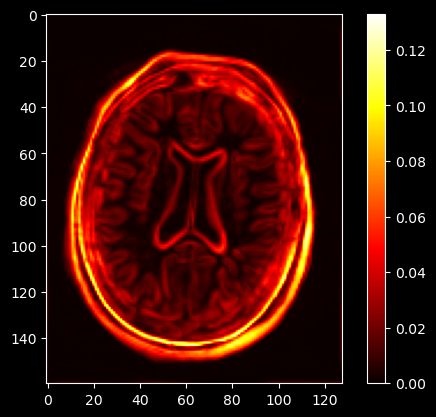

In [8]:
uncert = torch.load('var_uns.pth')
plt.imshow(uncert[6][0,0,:,:,70].T,cmap='hot',vmin=0)
plt.colorbar()

0.010051835744633586 0.03174563637806791 0.10025884372280366 0.3166367693790531 1.0


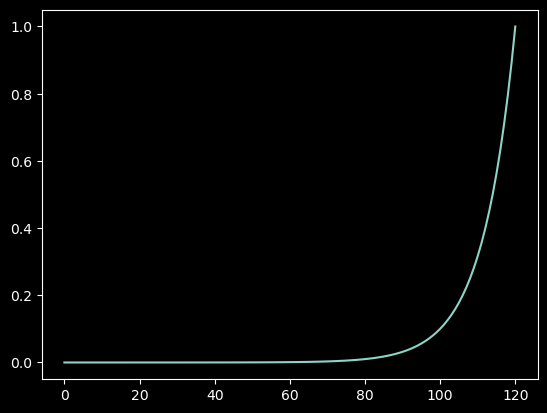

In [45]:
x = np.linspace(0,120,121)
y =np.exp(0.115*x-13.8)
plt.plot(x,y)
print(y[80],y[90],y[100],y[110],y[120])

In [41]:
2.7**2.3

9.820569140064718